In [1]:
# change working directory to the root of the project
import os
os.chdir('..')

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import pyprotoevo

sim_name = 'ourea-kadabra-qui'

In [4]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [5]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

In [81]:
genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 10 == 0
}

In [6]:
all_stats = set(stat for time_stamp in stats for stat in stats[time_stamp]['stats'])

In [7]:
black_list = ['Node', 'Organelle', 'Log', 'Molecule']
basic_stats = [
    stat for stat in all_stats
    if all(x not in stat for x in black_list)
]
', '.join(basic_stats)

'Construction Mass Mean, Sleeping, Num Mutations Mean, Meat Digestion Rate Mean, Num Engulfed Mean, Split Radius Mean, Died from exceeding environment capacity, Plants Created, Meat to Digest Count, Plant to Digest Count, Available Energy Mean, Died from being eaten, Died from old age, Protozoa, Meat Pellets, Size Mean, Num Cell Bindings Mean, Contacts, GRN Size Mean, Died from murder, Herbivore Factor Mean, Died from cytokinesis, Has Mated Mean, Joints, Fixtures, Meat to Digest Mean, Bodies, Num Spikes Count, Plant Digestion Rate Mean, Total Mass Mean, Num Cell Bindings Count, Max Plant Generation, Physics Step Time, Mean Mutation Chance Mean, Generation Mean, Proxies, Num Spikes Mean, Construction Mass Limit Mean, Speed Mean, Crossover Events, Growth Rate Mean, Death Rate Mean, Age Mean, Died from suffocation, Died from the void, Being Engulfed Mean, Plants, Repair Rate Mean, Time Elapsed, Health Mean, Protozoa Created, Died from overcrowding, Plant to Digest Mean, Meat Created, Num 

In [8]:
stat_types = {
    stat: record['unit']['units']
    for time_stamp in stats.keys()
    for stat, record in stats[time_stamp]['stats'].items()
    if record['unit'] is not None
}

In [9]:
def unit_to_string(unit: dict) -> str:
    '''
    Convert a unit dictionary to a string.
    For instance, {'MASS': 1, 'TIME': -1} becomes 'µg/s'.
    Possible base units are:
    - MASS: converted to micrograms (1e-6)
    - DISTANCE: converted to micrometers (1e-6)
    - TIME: converted to seconds (1)
    - ENERGY: converted to joules (1)
    - COUNT: converted to number (1)
    - ANGLE: converted to radians (1)
    - PERCENTAGE: converted to percentage (1)
    '''
    units = {
        'MASS': 'µg',
        'DISTANCE': 'µm',
        'TIME': 's',
        'ENERGY': 'J',
        'COUNT': '',
        'ANGLE': 'rad',
        'PERCENTAGE': '%'
    }
    return ''.join([
        units[key] + ('' if val == 1 else '^{' + str(val) + '}')
        for key, val in unit.items()
    ])

In [10]:
stat_type_strs = {
    stat: unit_to_string(unit)
    for stat, unit in stat_types.items()
}

In [11]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']

In [12]:
from datetime import datetime

In [13]:
generation_df = pd.DataFrame([
    {
        'Time': datetime(*map(int, time_stamp.split('-'))),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in stats.items()
]);
generation_df['Wall Time'] = generation_df['Time'] - generation_df['Time'].min()
generation_df['Next Time Stamp'] = generation_df['Time Stamp'].shift(-1)
generation_df.head()

,Time,Time Stamp,Generation,Wall Time,Next Time Stamp
0,2023-03-02 16:41:14,2023-03-02-16-41-14,1,0 days 00:00:00,2023-03-02-16-48-06
1,2023-03-02 16:48:06,2023-03-02-16-48-06,3,0 days 00:06:52,2023-03-02-16-54-21
2,2023-03-02 16:54:21,2023-03-02-16-54-21,4,0 days 00:13:07,2023-03-02-17-00-45
3,2023-03-02 17:00:45,2023-03-02-17-00-45,6,0 days 00:19:31,2023-03-02-17-07-09
4,2023-03-02 17:07:09,2023-03-02-17-07-09,7,0 days 00:25:55,2023-03-02-17-13-41


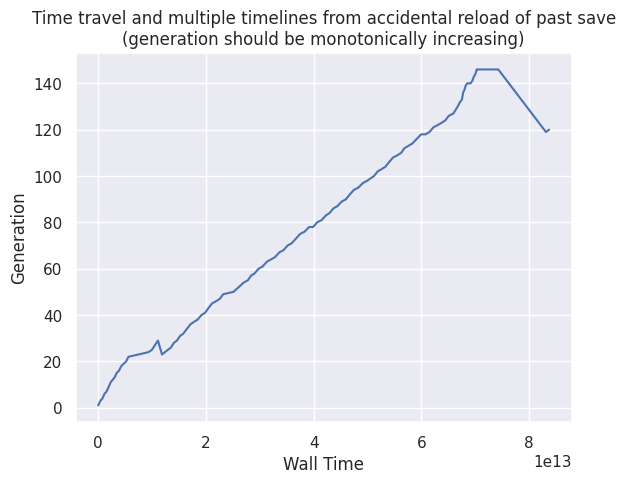

In [14]:
plt.title('Time travel and multiple timelines from accidental reload of past save\n(generation should be monotonically increasing)')
sns.lineplot(data=generation_df, x='Wall Time', y='Generation');

In [15]:
generation_df = generation_df.sort_values('Time Stamp')
records = generation_df.to_records()


def are_all_future_records_of_higher_generation(record):
    return all(
        record['Generation'] < records[i]['Generation']
        for i in range(record['index'] + 1, len(records))
    )


cleaned_stats = {
    (time_stamp := record['Time Stamp']) : stats[time_stamp]
    for record in records
    if are_all_future_records_of_higher_generation(record)
}

In [16]:
def get_datetime(time_stamp: str) -> datetime:
    return datetime(*map(int, time_stamp.split('-')))

In [17]:
generation_df_cleaned = pd.DataFrame([
    {
        'Time': get_datetime(time_stamp),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in cleaned_stats.items()
]);
generation_df_cleaned['Wall Time'] = generation_df_cleaned['Time'] - generation_df_cleaned['Time'].min()

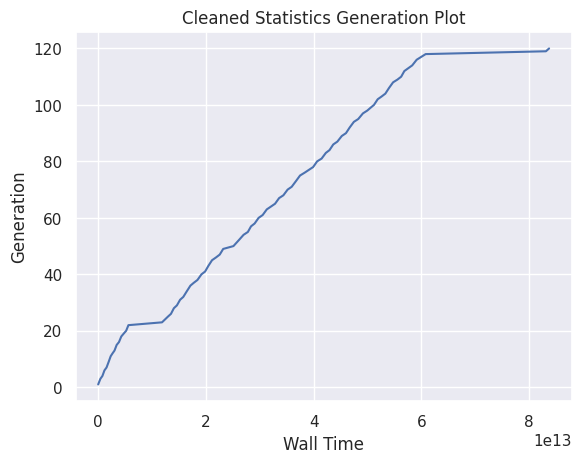

In [18]:
plt.title('Cleaned Statistics Generation Plot')
sns.lineplot(data=generation_df_cleaned, x='Wall Time', y='Generation');

In [178]:
stats = cleaned_stats

In [182]:
stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])
stats_df.fillna(0, inplace=True)
stats_df.replace(to_replace='NaN', value=0, inplace=True)
stats_df.head()

,Size Mean,Being Engulfed Mean,Available Energy Mean,Meat Digestion Rate Mean,Sleeping,Age Mean,Split Radius Mean,Plants Created,GRN Depth Mean,Death Rate Mean,...,Num Cell Bindings Count,Died from old age,Num Spikes Count,Meat to Digest Mean,Meat to Digest Count,Plant to Digest Mean,Died from suffocation,Num Spikes Mean,Died from cytokinesis,Died from running out of health
0,0.060950,0.0,1.000000,0.902813,0.0,0.000000,0.116349,1286,2.300000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.056326,0.0,633.187433,0.967959,32.472229,14.305291,0.097872,9801,2.382470,4.506078,...,2.0,659.0,26.0,0.000035,190.0,0.000041,1899.0,1.038462,2165.0,0.0
2,0.049099,0.0,1585.323587,0.988470,45.808105,6.967864,0.093776,16482,2.588608,3.927931,...,2.0,1906.0,7.0,0.000007,78.0,0.000069,3034.0,1.000000,4400.0,0.0
3,0.054104,0.0,1913.109174,1.071154,29.724771,8.789297,0.090831,21264,2.743860,4.328332,...,6.0,2228.0,2.0,0.000032,150.0,0.000086,4026.0,1.000000,5953.0,0.0
4,0.052241,0.0,1728.419442,1.245298,30.43675,8.811310,0.091911,25970,2.735060,4.179286,...,4.0,2791.0,7.0,0.000047,260.0,0.000060,4808.0,1.000000,7436.0,0.0


<AxesSubplot: xlabel='Generation Mean', ylabel='Protozoa'>

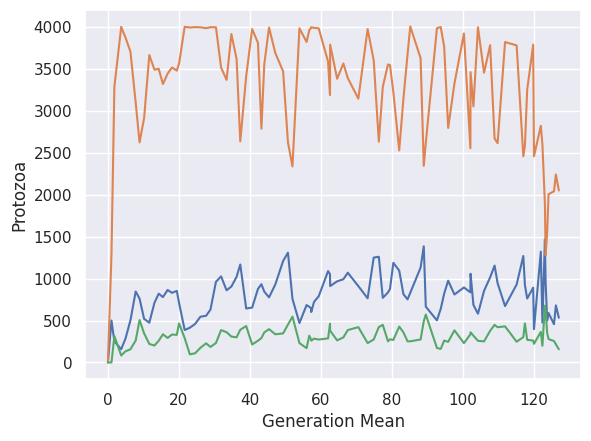

In [180]:
sns.lineplot(data=stats_df, x='Generation Mean', y='Protozoa')
sns.lineplot(data=stats_df, x='Generation Mean', y='Plants')
sns.lineplot(data=stats_df, x='Generation Mean', y='Meat Pellets')

In [183]:
stats_df.columns

Index(['Size Mean', 'Being Engulfed Mean', 'Available Energy Mean',
       'Meat Digestion Rate Mean', 'Sleeping', 'Age Mean', 'Split Radius Mean',
       'Plants Created', 'GRN Depth Mean', 'Death Rate Mean', 'Speed Mean',
       'Num Mutations Mean', 'Contacts', 'Joints', 'Health Mean',
       'Generation Mean', 'Growth Rate Mean', 'GRN Size Mean', 'Protozoa',
       'Physics Step Time', 'Total Mass Mean', 'Fixtures',
       'Herbivore Factor Mean', 'Plant Digestion Rate Mean',
       'Crossover Events', 'Time Elapsed', 'Plants', 'Protozoa Created',
       'Proxies', 'Has Mated Mean', 'Construction Mass Mean', 'Meat Pellets',
       'Max Plant Generation', 'Max Protozoa Generation',
       'Construction Mass Limit Mean', 'Mean Mutation Chance Mean',
       'Died from exceeding environment capacity', 'Bodies',
       'Repair Rate Mean', 'Num Engulfed Count', 'Died from murder',
       'Num Cell Bindings Mean', 'Num Engulfed Mean', 'Died from being eaten',
       'Died from the void', 

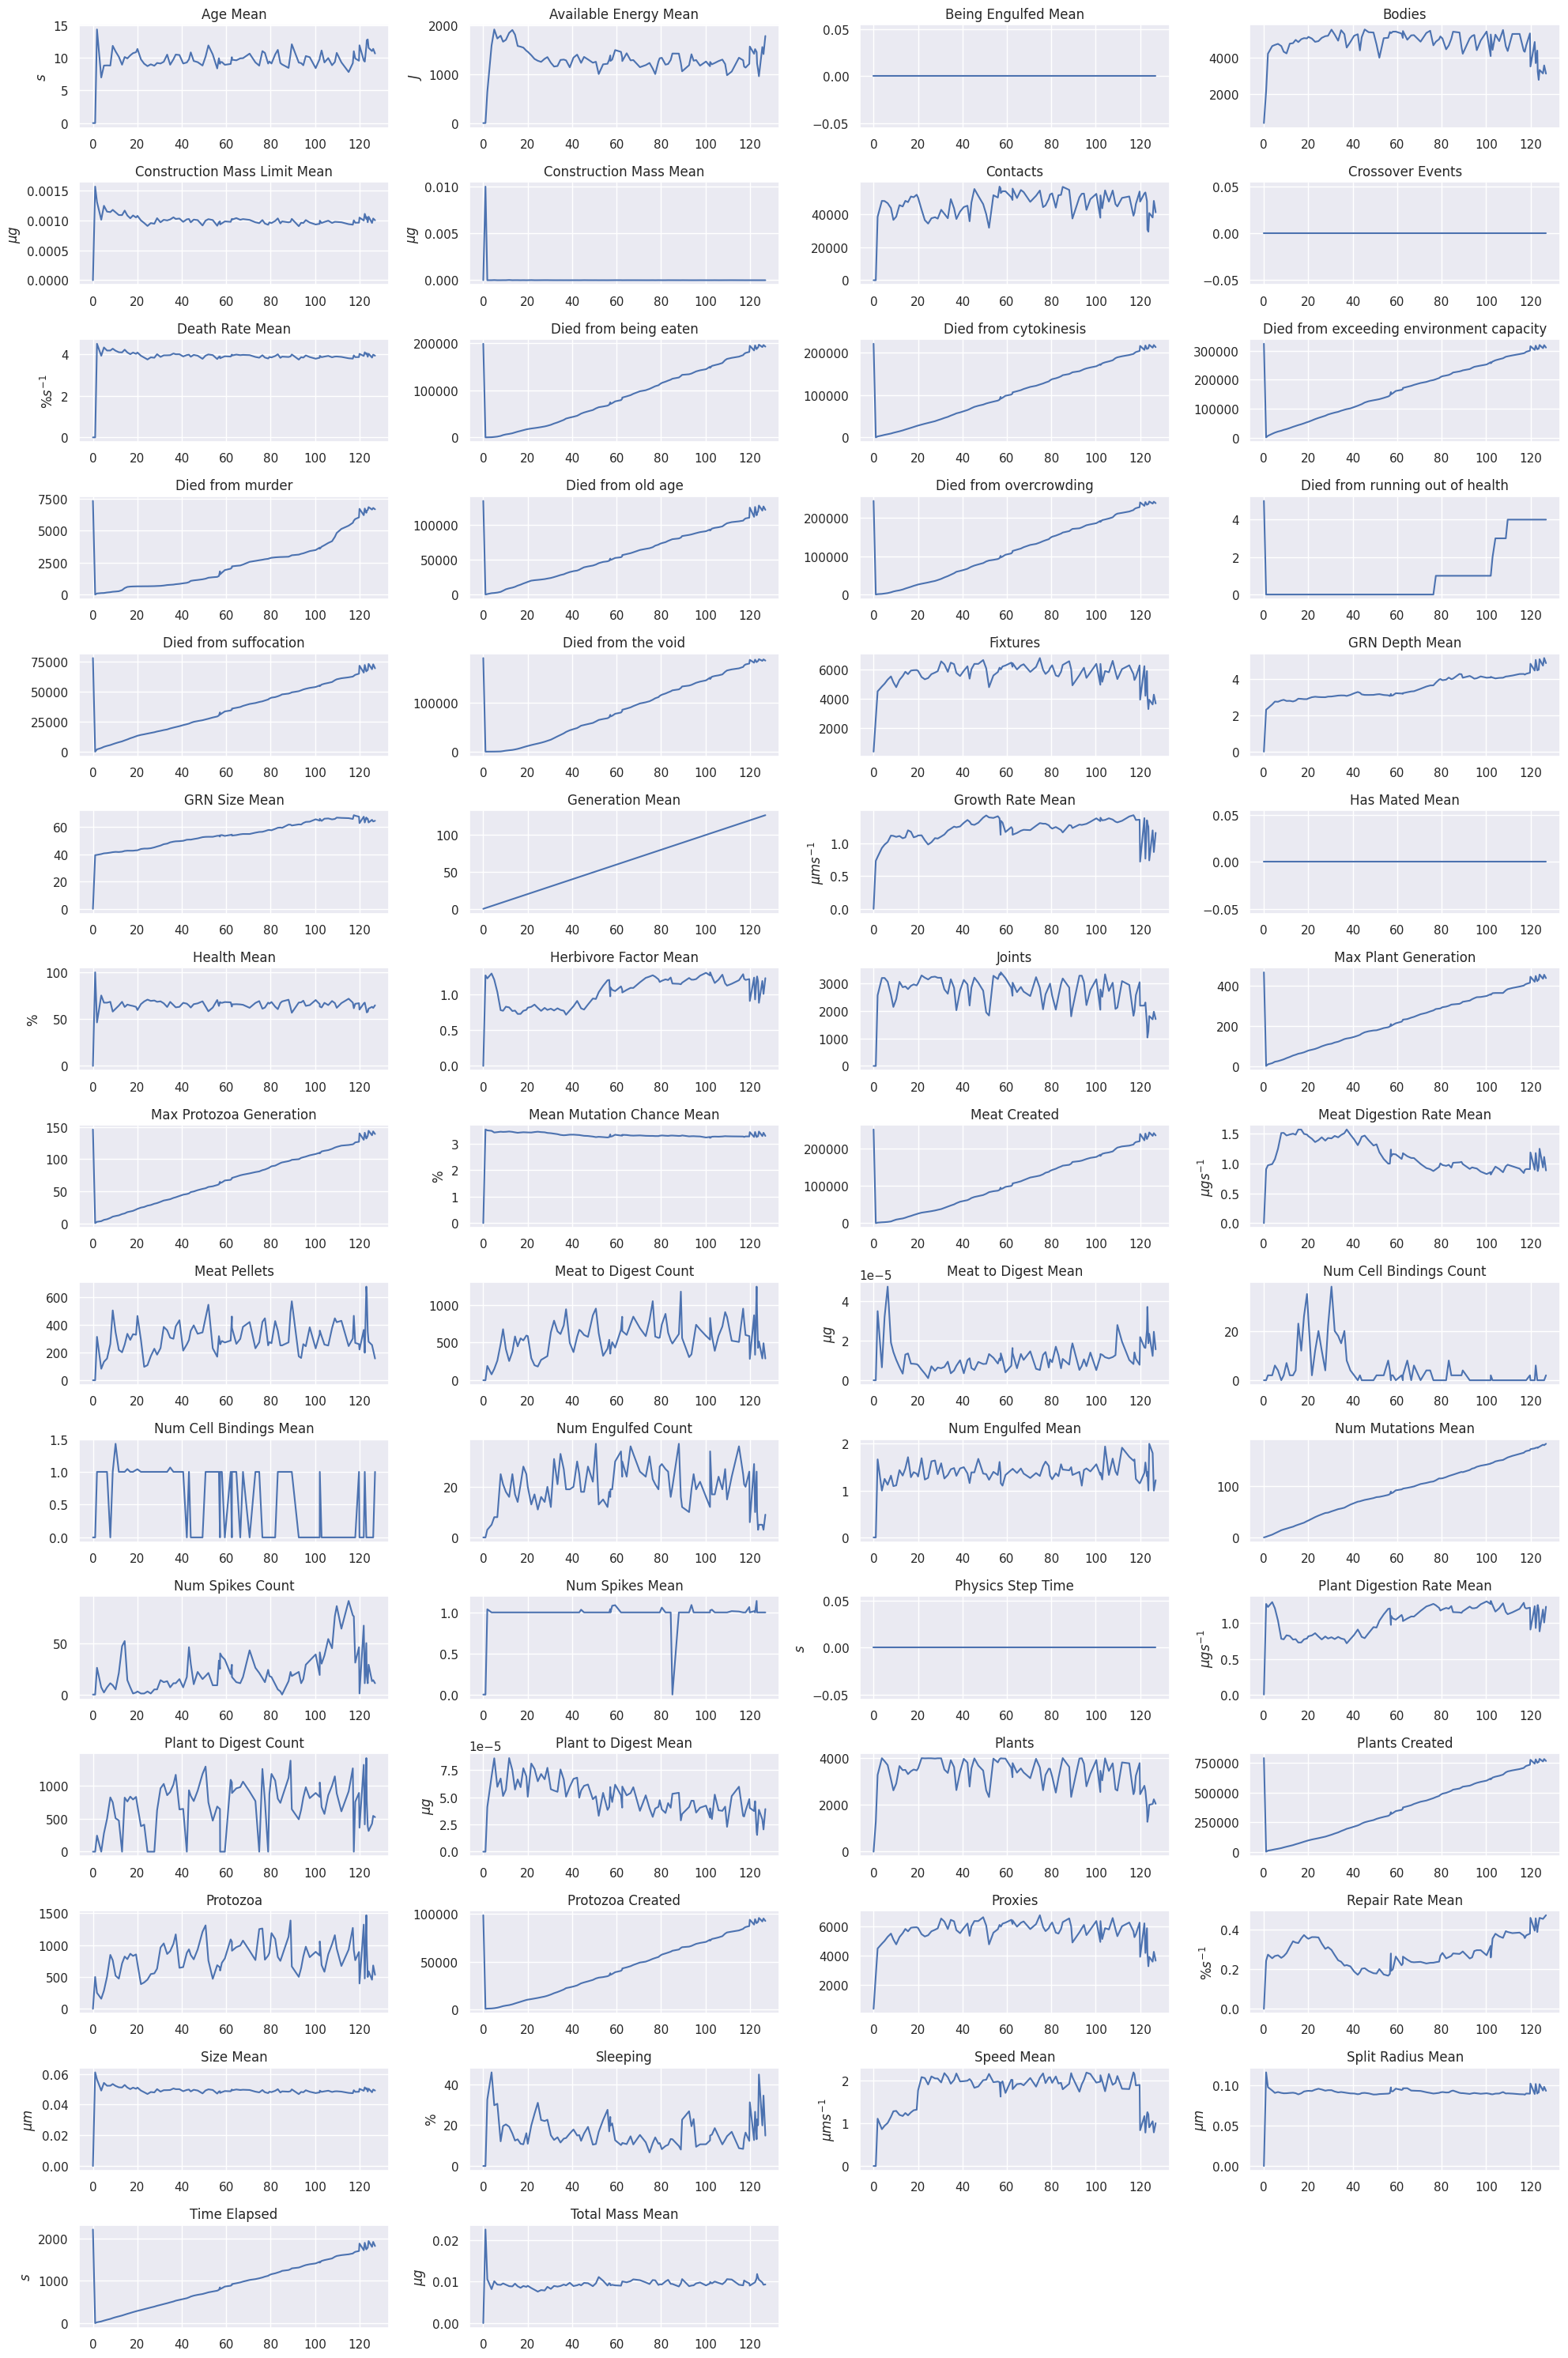

In [195]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
rows = int(np.ceil(stats_df.columns.size / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stats_df.columns)):
    if stat is not None:
        sns.lineplot(data=stats_df, x='Generation Mean', y=stat, ax=ax)
        ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['frequency'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
    if time in stats
])

In [ ]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,frequency
0,-9223298227701593280,1,2023-03-02-16-41-14,1.00000,500,0.002000
1,3028957027645669649,1,2023-03-02-16-41-14,1.00000,500,0.002000
2,3029392523589143722,1,2023-03-02-16-41-14,1.00000,500,0.002000
3,3029642484756531015,1,2023-03-02-16-41-14,1.00000,500,0.002000
4,3029931697029596387,1,2023-03-02-16-41-14,1.00000,500,0.002000
...,...,...,...,...,...,...
2956,-3104709557010477876,1,2023-03-03-10-46-21,118.06168,762,0.001312
2957,4092190014155801461,1,2023-03-03-10-46-21,118.06168,762,0.001312
2958,4098813527039885536,1,2023-03-03-10-46-21,118.06168,762,0.001312
2959,-3126467345721440315,1,2023-03-03-10-46-21,118.06168,762,0.001312


In [ ]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(100))\
    .reset_index()
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-8469246420843936082,128100.000000,1323.337666,75927.777778,0.115012
1,2074060241260660010,42405.238095,857.660999,65812.476190,0.112626
2,5696769961235926407,42405.238095,857.660999,65812.476190,0.112626
3,-4194016379000828326,42405.238095,857.660999,65812.476190,0.112626
4,-8591072557852766345,123117.250000,1323.337666,75927.777778,0.094127


In [ ]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='frequency')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


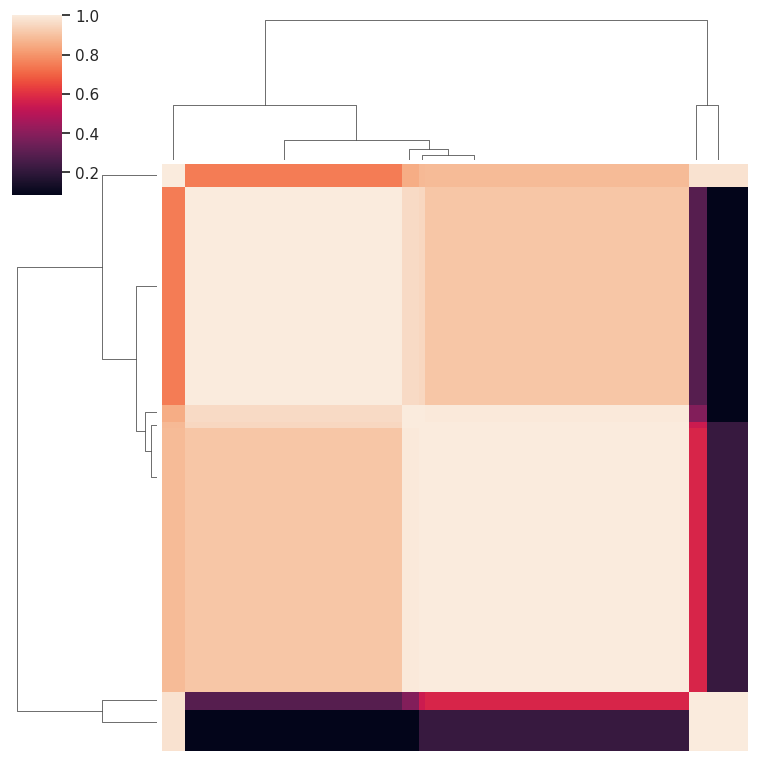

In [ ]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [ ]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.1 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters_ids = np.unique(idx)
clusters = {
    cluster_id: [signature for signature, cluster in signature_clusters.items() if cluster == cluster_id]
    for cluster_id in clusters_ids
}
clusters_ids

array([1, 2, 3, 4, 5], dtype=int32)

In [135]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var frequency'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

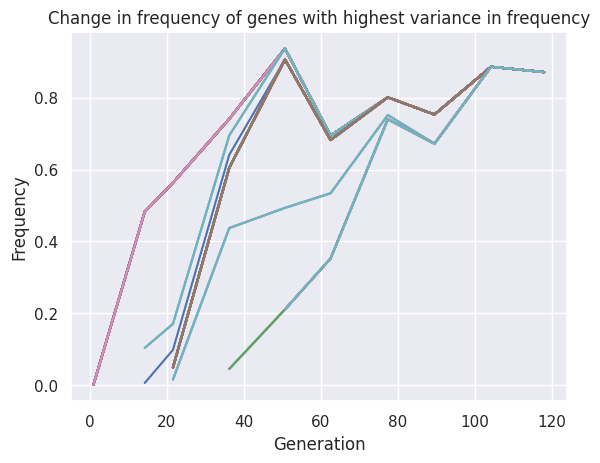

In [136]:
for gene in high_var_genes_df['signature'].unique():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

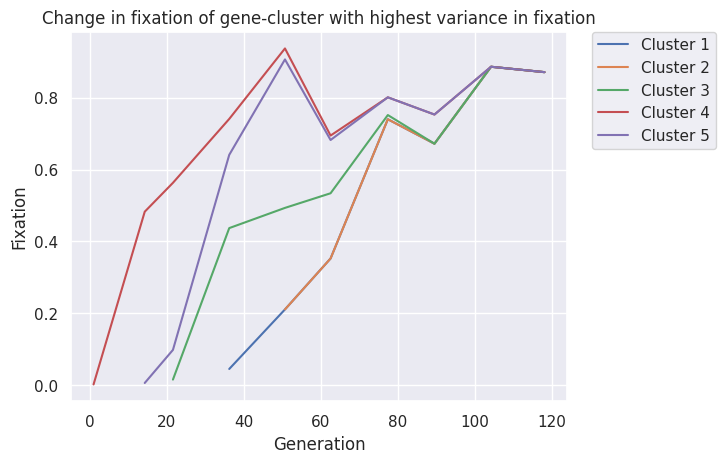

In [137]:
for cluster_id, gene in cluster_prototypes.items():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'], label=f'Cluster {cluster_id}')
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
# legend outside of plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [138]:
last_generation_time_stamp = max(genomes.keys(), key=get_datetime)
last_generation_time_stamp

last_generation_signatures = set([
    gene['signature']
    for genome in genomes[last_generation_time_stamp]
    for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
])

survived_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(last_generation_signatures)]
survived_genes_df.head()

,signature,count,time,generation,num_protozoa,frequency
282,3103965977712152527,1,2023-03-02-16-41-14,1.0,500,0.002
300,3091860970844277126,1,2023-03-02-16-41-14,1.0,500,0.002
405,3068207678668293927,1,2023-03-02-16-41-14,1.0,500,0.002
504,3077957540399500242,1,2023-03-02-16-41-14,1.0,500,0.002
888,2969292268005639450,1,2023-03-02-16-41-14,1.0,500,0.002


In [139]:
survived_variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
survived_variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-8469246420843936082,128100.000000,1323.337666,75927.777778,0.115012
1,2074060241260660010,42405.238095,857.660999,65812.476190,0.112626
2,5696769961235926407,42405.238095,857.660999,65812.476190,0.112626
3,-4194016379000828326,42405.238095,857.660999,65812.476190,0.112626
4,-8591072557852766345,123117.250000,1323.337666,75927.777778,0.094127


In [140]:
survived_high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(survived_variance_df['signature'])]

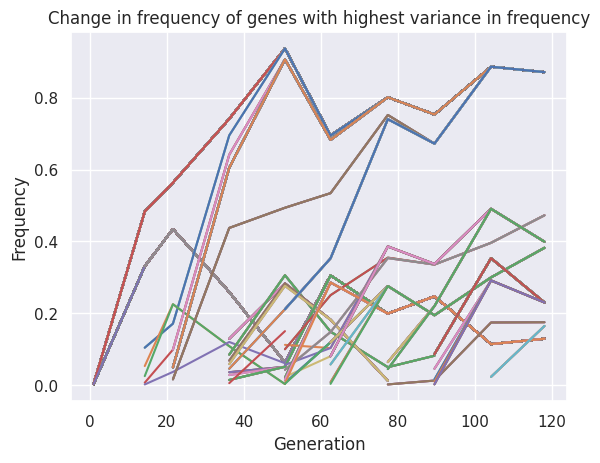

In [141]:
for gene in survived_high_var_genes_df['signature'].unique():
    gene_ts = survived_high_var_genes_df[survived_high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

In [142]:
variance_df['cluster id'] = variance_df['signature'].map(signature_clusters)
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency,cluster id
0,-8469246420843936082,128100.000000,1323.337666,75927.777778,0.115012,5
1,2074060241260660010,42405.238095,857.660999,65812.476190,0.112626,1
2,5696769961235926407,42405.238095,857.660999,65812.476190,0.112626,1
3,-4194016379000828326,42405.238095,857.660999,65812.476190,0.112626,1
4,-8591072557852766345,123117.250000,1323.337666,75927.777778,0.094127,5


In [34]:
variance_df.groupby('cluster id').var()

,signature,var count,var generation,var num_protozoa,var frequency
cluster id,,,,,
1,4.484679e+37,0.000000e+00,0.00000,0.000000e+00,0.000000
2,2.864903e+37,2.266721e+06,138.07092,1.288129e+07,0.000014
